In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from statsmodels.tsa.api import Holt
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

In [21]:
dataframe = pd.read_csv('MATICUSDT_list.csv', delimiter=';', names=[
    'openTime',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'closeTime'
])

In [22]:
dataframe.dtypes

openTime       int64
open         float64
high         float64
low          float64
close        float64
volume       float64
closeTime      int64
dtype: object

In [23]:
dataframe['openTime'] = pd.to_datetime(dataframe['openTime'], unit='ms', errors='coerce')
dataframe['closeTime'] = pd.to_datetime(dataframe['closeTime'], unit='ms', errors='coerce')

In [24]:
data = list(dataframe['close'])
index = dataframe['closeTime']
livestock = pd.Series(data, index)

In [25]:
fit = Holt(livestock, exponential=True).fit(0.06, 0.06, optimized=False)

In [26]:
def delete_adjacent_extremums(values, peaks_, mins_, extremums_):
    for j in range(len(extremums_) - 1):
        if extremums_[j] in peaks_:
            peak_count = 1
            if extremums_[j + 1] in mins_:
                j += 1
            else:
                while extremums_[j + peak_count] in peaks_:
                    peak_count += 1
                max_pack = deepcopy(extremums_[[tuple(range(j, j + peak_count))]])
                maximum_index = extremums_[j + values[extremums_[[tuple(range(j, j + peak_count))]]].argmax()]
                to_delete = deepcopy(max_pack[np.where(max_pack != maximum_index)])
                for d in to_delete:
                    peaks_ = np.delete(peaks_, np.argwhere(peaks_ == d))
        else:
            min_count = 1
            if extremums_[j + 1] in peaks_:
                j += 1
            else:
                while extremums_[j + min_count] in mins_:
                    min_count += 1
                min_pack = deepcopy(extremums[[tuple(range(j, j + min_count))]])
                minimum_index = extremums_[j + values[extremums_[[tuple(range(j, j + min_count))]]].argmin()]
                to_delete = deepcopy(min_pack[np.where(min_pack != minimum_index)])
                for d in to_delete:
                    mins_ = np.delete(mins_, np.argwhere(mins_ == d))
                j += min_count
    return peaks_, mins_ 

(2.506, 2.603)

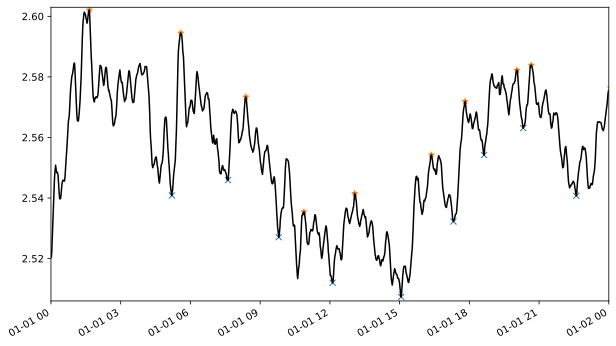

In [27]:
day = datetime.strptime('2022-01-01', '%Y-%m-%d')
start_timestamp = pd.Timestamp(day.strftime('%Y-%m-%d'))
finish_timestamp = pd.Timestamp((day + timedelta(days=1)).strftime('%Y-%m-%d'))

extremum_width = int(len(dataframe.loc[(dataframe['closeTime'] >= start_timestamp) & (dataframe['closeTime'] <= finish_timestamp)])/70)
extremum_prominence = fit.fittedvalues.mean()/1000
peaks, _ = find_peaks(fit.fittedvalues, width=extremum_width, prominence=extremum_prominence)
mins, _ = find_peaks(fit.fittedvalues*-1, width=extremum_width, prominence=extremum_prominence)
extremums = np.sort(np.concatenate([peaks, mins]))

peaks, mins = delete_adjacent_extremums(fit.fittedvalues, peaks, mins, extremums)
extremums = np.sort(np.concatenate([peaks, mins]))

local_minimum = dataframe.loc[(dataframe['closeTime'] >= start_timestamp) & (dataframe['closeTime'] <= finish_timestamp)]['close'].min()
local_maximum = dataframe.loc[(dataframe['closeTime'] >= start_timestamp) & (dataframe['closeTime'] <= finish_timestamp)]['close'].max()
fig, ax = plt.subplots()

# ax.plot(dataframe['closeTime'], dataframe['close'], color='black')
# ax.plot(dataframe['closeTime'][mins],  dataframe['close'][mins], 'x', label='mins')
# ax.plot(dataframe['closeTime'][peaks],  dataframe['close'][peaks], '*', label='peaks')
ax.plot(dataframe['closeTime'][mins],  fit.fittedvalues[mins], 'x', label='mins')
ax.plot(dataframe['closeTime'][peaks],  fit.fittedvalues[peaks], '*', label='peaks')
# ax.plot(fit1.fittedvalues, color="blue")
ax.plot(fit.fittedvalues, color="black")

fig.autofmt_xdate()
ax.set_xlim(left=start_timestamp,
           right=finish_timestamp)
ax.set_ylim(bottom=local_minimum,
           top=local_maximum)

# fig.savefig('width.png')

In [28]:
print("Peaks count: " + str(len(peaks)))
print("Mins count: " + str(len(mins)))

Peaks count: 4547
Mins count: 4546


In [10]:
signals = np.array([])
if peaks[0] < mins[0]:
    signal = True
else:
    signal = False
for i in tqdm(range(len(dataframe))):
    signals = np.append(signals, signal)
    if i in extremums:
        signal = not signal

  0%|          | 0/1455406 [00:00<?, ?it/s]

In [11]:
dataframe['signal'] = signals
dataframe.to_csv('MATICUSDT_signal.csv', sep=';')